# This notebook shows retrieve a model and data from an model dump file. 
The model is then simulated and the results are displayed. 

## Why specify a model in Latex? 

Sometime the **implementation** of a model in software don't match the **specification** of the model in 
the text in which the model is presented. It can be a chalange to make sure that the specification is 
updated in order to reflect changes made in the implementation. 

By extracting the model from a Latex script which describes and specify the model a one can always be sure that simulations reflect the model as described in the paper. 

Also the author is forced to make a complete specification of the model, else it won't run. 

## The Economic Credit Loss model 
This jupyter notebook is inspired by IMF working paper (WP/20/111) The Expected Credit Loss Modeling from a Top-Down Stress Testing Perspective by Marco Gross, Dimitrios Laliotis, Mindaugas Leika, Pavel Lukyantsau. The working paper and the associated material is located https://www.imf.org/en/Publications/WP/Issues/2020/07/03/Expected-Credit-Loss-Modeling-from-a-Top-Down-Stress-Testing-Perspective-49545

from the abstract of the paper: 
> The objective of this paper is to present an integrated tool suite for IFRS 9- and CECL compatible
estimation in top-down solvency stress tests. The tool suite serves as an
illustration for institutions wishing to include accounting-based approaches for credit risk
modeling in top-down stress tests.

This is a jupyter notebook build with the purpose of illustrating the use of ModelFlow. The purpose is testing so take very much care.  

## Import libraries 

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.core.display import HTML,Markdown,Latex
from ipywidgets import interact,Dropdown,Checkbox



from modelclass import model
import modeljupytermagic
import modeljupyter as mj


# some useful stuf
model.widescreen()
pd.set_option('display.max_rows', None, 'display.max_columns', 10, 'precision', 2)
sortdf = lambda df: df[sorted([c for c in df.columns])]

## Fetch the precooked model and baseline 
The model and data has been specified in another Jupyter notebook: 

[file/Model for economic credit loss with Z score transition nynamic - setup]

In [2]:
ecl,baseline  = model.modelload('ecl.pcim')
newindex = pd.period_range("2021", periods=len(baseline), freq="Y")
baseline.index = newindex
newindex

PeriodIndex(['2021', '2022', '2023', '2024', '2025', '2026', '2027'], dtype='period[A-DEC]', freq='A-DEC')

In [3]:
xx = pd.period_range(start=2021,freq = 'Y',periods=3)
xx

PeriodIndex(['2021', '2022', '2023'], dtype='period[A-DEC]', freq='A-DEC')

## The modelspecification - in latex
This is the rendering of the latex input, which has specified the model. 

So the model is extracted from the Latex script, which produces the output below

In [4]:
Markdown(ecl.equations_latex)



### Loans can be in 3 stages
Loans can be in 3 stages, s1,s2 and s3. 
New loans will be generated and loans will mature. 


Two lists of stages are defined: 
    
List $stage=\{s1, s2,s3\}$

List $stage\_from=\{s1, s2,s3\}$

### A share of the loans in each stage wil transition to the same or another stage in the next time frame:  

\begin{equation}
\label{eq:loanfromto}
loan\_transition\_from\_to^{stage\_from,stage}_{t} = loan^{stage\_from}_{t-1} \times TR^{stage\_from,stage}_{t} 
\end{equation}

\begin{equation}
\label{eq:transition}
loan\_transition\_to^{stage}_{t}  = \underbrace{\sum_{stage\_from}(loan\_transition\_from\_to^{stage\_from,stage}_{t})}_{Transition}
\end{equation}

### A share of the loans in each stage will mature another share will have to be written off

\begin{equation}
\label{eq:maturing}
loan\_maturing^{stage}_{t}  = M^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}

\begin{equation}
\label{eq:writeoff}
loan\_writeoff^{stage}_{t}  = WRO^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}

### So loans in a stage will reflect the inflow and outflow

\begin{equation}
\label{eq:E}
loan^{stage}_{t}  = \underbrace{loan\_transition\_to^{stage}_{t} }_{Transition}
-\underbrace{loan\_maturing^{stage}_{t}}_{Maturing}
-\underbrace{loan\_writeoff^{stage}_{t}}_{Writeoff}
+\underbrace{loan\_new^{stage}_{t}}_{New loans}
\end{equation}


\begin{equation}
\label{eq:new}
loan\_new^{stage}_{t}  = new^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}
 
\begin{equation}
\label{eq:g}
loan\_total_{t}  =  \sum_{stage}(loan^{stage}_{t})
\end{equation}


### New loans are only generated in stage 1.

\begin{equation}
\label{eq:E2}
new\_s1_{t} = \frac{loan\_growth_{t} \times loan\_total_{t-1} + 
                \sum_{stage}((M^{stage}_{t}+WRO^{stage}_{t})\times loan^{stage}_{t-1})}{(loan\_s1_{t-1})}
\end{equation}

### Performing Loans 

\begin{equation}
\label{eq:Performing}
loan\_performing_{t} = loan\_s1_{t}+loan\_s2_{t}
\end{equation}

### Cure 

\begin{equation}
\label{eq:cure}
loan\_cure = loan\_transition\_from\_to\_s3\_s1+loan\_transition\_from\_to\_s3\_s2
\end{equation}

### PD pit

\begin{equation}
\label{eq:PDPIT}
PD\_pit= \frac{loan\_transition\_from\_to\_s1\_s3+loan\_transition\_from\_to\_s2\_s3}{loan\_s1+loan\_s2}
\end{equation}

\begin{equation}
\label{eq:PDTTC}
PD\_TTC = logit^{-1}(logit(PD\_TTC(-1)) + alfa \times \Delta{PD\_pit})
\end{equation}

### And we can specify the dynamic of the transition matrix, based on Z score

Let $\Phi$ be the normal cumulative distribution $\frac{1}{\sqrt{2\pi}}
\int_{-\infty}^x e^{
-\frac{t^2}{2}}dt$



\begin{equation}
\label{eq:tr}
TR^{stage\_from,stage}_{t} = \Phi{\left(\frac{bound\_upper^{stage\_from,stage}-\sqrt{\rho}\times Z_{t}}{\sqrt{1-\rho}}\right)}-\Phi{\left(\frac{bound\_lower^{stage\_from,stage}-\sqrt{\rho}\times Z_{t}}{\sqrt{1-\rho}}\right)}
\end{equation}




## Input values for the adverse scenario

In [5]:
%%dataframe projection_adverse show
LOAN_GROWTH	M_S1	M_S2	WRO_S3	Z
0	1.00e-02	0.04	0.03	0.06	0.00
1	-1.00e-02	0.04	0.03	0.06	-0.65
2	-8.00e-03	0.04	0.03	0.06	-0.84
3	-6.00e-03	0.04	0.03	0.06	-0.99
4	-4.00e-03	0.04	0.03	0.06	-0.69
5	-2.00e-03	0.04	0.03	0.06	-0.39
6	-0.00e+00	0.04	0.03	0.06	-0.24

,LOAN_GROWTH,M_S1,M_S2,WRO_S3,Z
0,1.00e-02,0.04,0.03,0.06,0.00
1,-1.00e-02,0.04,0.03,0.06,-0.65
2,-8.00e-03,0.04,0.03,0.06,-0.84
3,-6.00e-03,0.04,0.03,0.06,-0.99
4,-4.00e-03,0.04,0.03,0.06,-0.69
5,-2.00e-03,0.04,0.03,0.06,-0.39
6,-0.00e+00,0.04,0.03,0.06,-0.24


## Create an adverse Dataframe

In [6]:
adverse = baseline.copy()
projection_adverse.index = baseline.index
adverse.update(projection_adverse)
adverse.T

,2021,2022,2023,2024,2025,2026,2027
TR_S1_S1,0.89,8.97e-01,9.01e-01,9.05e-01,9.06e-01,9.08e-01,9.09e-01
TR_S2_S1,0.15,7.46e-02,7.82e-02,8.11e-02,8.26e-02,8.42e-02,8.50e-02
TR_S3_S1,0.02,9.72e-03,1.04e-02,1.10e-02,1.12e-02,1.15e-02,1.17e-02
TR_S1_S2,0.09,9.44e-02,9.05e-02,8.75e-02,8.61e-02,8.46e-02,8.39e-02
TR_S2_S2,0.79,8.70e-01,8.70e-01,8.69e-01,8.68e-01,8.68e-01,8.67e-01
TR_S3_S2,0.24,1.79e-01,1.85e-01,1.90e-01,1.92e-01,1.95e-01,1.96e-01
TR_S1_S3,0.02,8.89e-03,8.31e-03,7.87e-03,7.65e-03,7.45e-03,7.34e-03
TR_S2_S3,0.06,5.50e-02,5.22e-02,5.01e-02,4.91e-02,4.81e-02,4.76e-02
TR_S3_S3,0.74,8.12e-01,8.05e-01,7.99e-01,7.96e-01,7.93e-01,7.92e-01
LOAN_S1,500.00,4.78e+02,4.65e+02,4.57e+02,4.53e+02,4.52e+02,4.53e+02


In [7]:
def df_extend(df,add=5):
    '''Extends a Dataframe, assumes that the indes is of period_range type'''
    newindex = pd.period_range(df.index[0], periods=len(df)+add, freq=df.index.freq)
    return df.reindex(newindex,method='ffill')

In [8]:

newbase = df_extend(baseline,10)
newadverse = df_extend(adverse,10)

## Run Model
For the Baseline and the adverse scenario 

In [9]:
base_result  = ecl(newbase,keep='Baseline')
adverse_result = ecl(newadverse,keep = 'Adverse')

Will start calculating: testmodel
2022  solved
2023  solved
2024  solved
2025  solved
2026  solved
2027  solved
2028  solved
2029  solved
2030  solved
2031  solved
2032  solved
2033  solved
2034  solved
2035  solved
2036  solved
2037  solved
testmodel calculated 
Will start calculating: testmodel
2022  solved
2023  solved
2024  solved
2025  solved
2026  solved
2027  solved
2028  solved
2029  solved
2030  solved
2031  solved
2032  solved
2033  solved
2034  solved
2035  solved
2036  solved
2037  solved
testmodel calculated 


## Inspect Results
The ecl instance of the model class has a number of methods and properties wich allows the analysis and display of results. 

### The difference in exogeneous variables (the input variable)

In [10]:
ecl.exodif()

,LOAN_GROWTH,M_S1,M_S2,WRO_S3,Z
2021,0.00,-0.01,-8.00e-03,-0.01,0.00
2022,-0.02,-0.01,-8.00e-03,-0.01,-0.18
2023,-0.02,-0.01,-8.00e-03,-0.01,-0.42
2024,-0.02,-0.01,-8.00e-03,-0.01,-0.61
2025,-0.01,-0.01,-8.00e-03,-0.01,-0.33
2026,-0.01,-0.01,-8.00e-03,-0.01,-0.05
2027,-0.01,-0.01,-8.00e-03,-0.01,0.09
2028,-0.01,-0.01,-8.00e-03,-0.01,0.09
2029,-0.01,-0.01,-8.00e-03,-0.01,0.09
2030,-0.01,-0.01,-8.00e-03,-0.01,0.09


### Loan growth

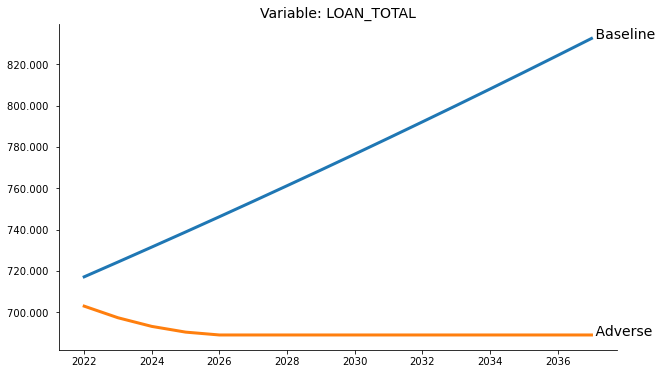

In [11]:
ecl.keep_plot('loan_total',showtype='level',legend=0);

### Transition probabilities 

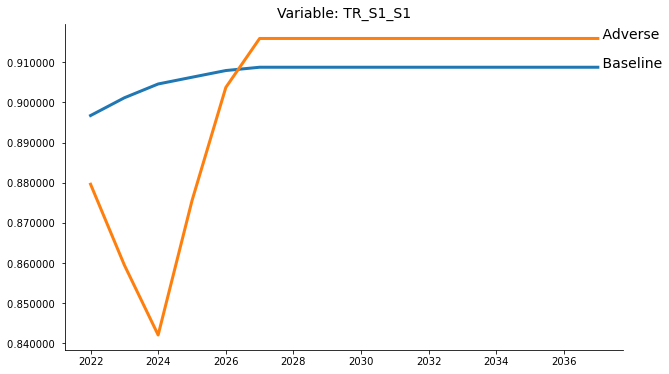

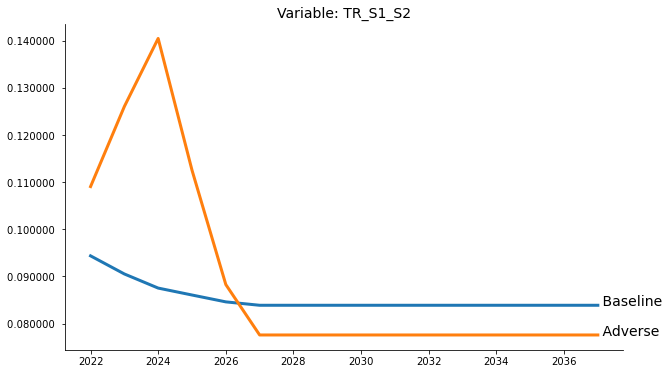

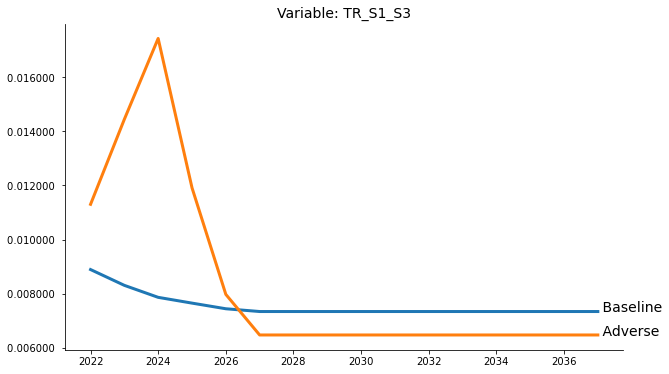

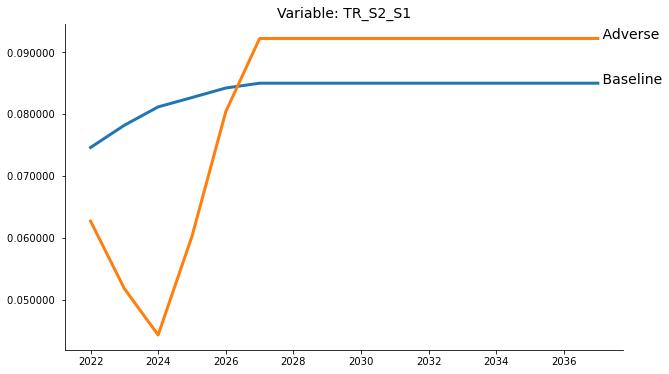

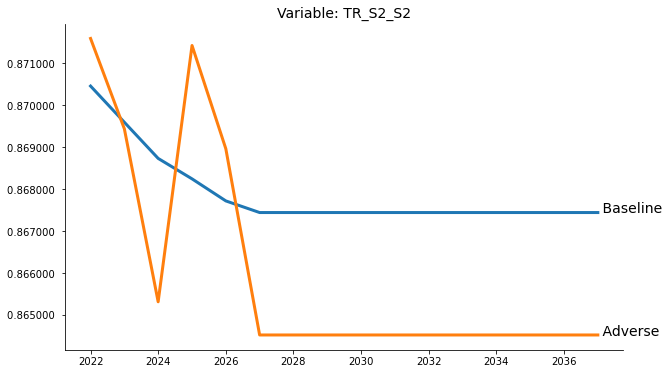

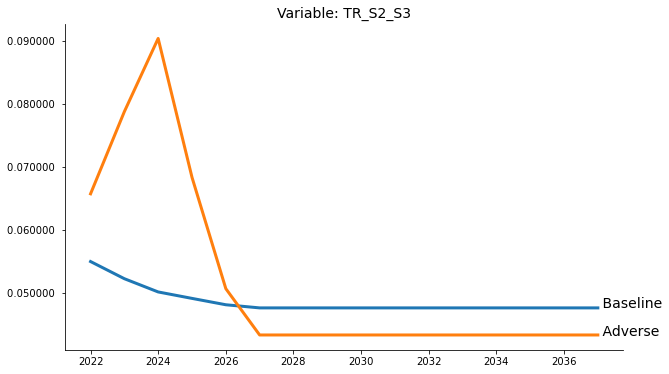

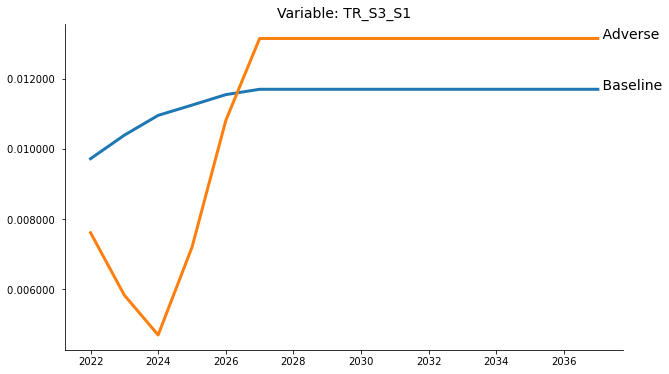

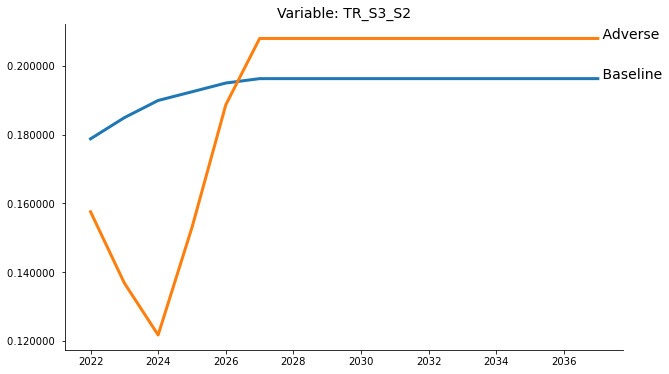

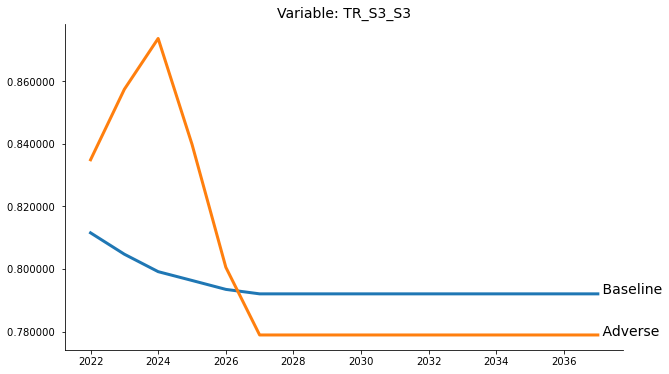

In [12]:
ecl.keep_plot('tr_*   ',showtype='level',legend=False);

### We can look at the structure of the model 

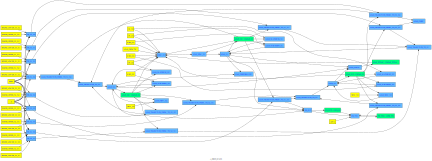

In [13]:
ecl.drawmodel(HR=0)

### Or just one variable and trace the variable preceding it 
And look at their values 

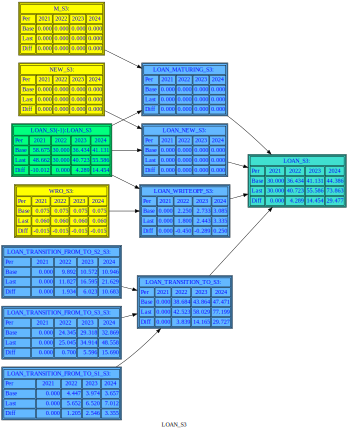

In [14]:
with ecl.set_smpl('2021','2024'):
    ecl.loan_s3.tracepre(all=1,HR=0,fpdf=0,up=2)

### Or use an interactive inspector to find find the attribution to individual 

In [15]:
@interact
def explain(Variable=Dropdown(options = sorted(ecl.endogene),value='LOAN_TOTAL'),
            Levels=[0,1,2,3]):
    mj.get_frml_latex(ecl,Variable)
    _ = ecl.explain(Variable,up=Levels,svg=1,dec=2,size=(10,10),des=1)

interactive(children=(Dropdown(description='Variable', index=11, options=('LOAN_CURE', 'LOAN_MATURING_S1', 'LO…

### What exogenous input drives Probability of Default (point in time - PD_PIT) 

We want to find out how much of the difference in the results from the baseline and adverse 
which can be explained by the different exogenous variables. 

This requires shocking each exogenous variable each period, simulating the model for each experiment and save the results. 

All done by calling one method: 

Total dekomp took       :         0.1740453243 Seconds


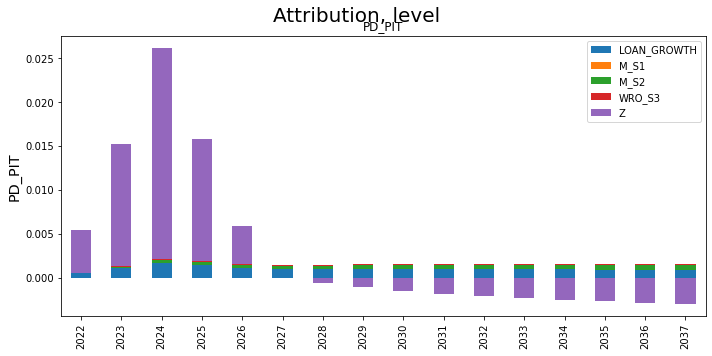

In [16]:
ecl.totexplain('PD_PIT');

In [17]:
from model_ifrs9 import lt_ifrs9
from modelmanipulation import explode 
fmodel = '''\
list leadlist = lead : 1 2 3 4 5 6 7 8 9 10 
lt_loss = lt_ifrs(5,0.01,0.20,to_array(leadlist,pd_pit(+{lead})))
'''
mifrs9 = model.from_eq(fmodel,funk=[lt_ifrs9])
print(mifrs9.equations)
#mifrs9(base_result,solver='xgenr')

LIST LEADLIST = LEAD : 1 2 3 4 5 6 7 8 9 10 $
FRML <> LT_LOSS = LT_IFRS(5,0.01,0.20,ARRAY(
[PD_PIT(+1),PD_PIT(+2),PD_PIT(+3),PD_PIT(+4),PD_PIT(+5),PD_PIT(+6),PD_PIT(+7),PD_PIT(+8),PD_PIT(+9),PD_PIT(+10)])) $


In [18]:
mifrs9(base_result,solver='xgenr')

Will start calculating: testmodel
Error in FRML <> LT_LOSS = LT_IFRS(5,0.01,0.20,ARRAY(
[PD_PIT(+1),PD_PIT(+2),PD_PIT(+3),PD_PIT(+4),PD_PIT(+5),PD_PIT(+6),PD_PIT(+7),PD_PIT(+8),PD_PIT(+9),PD_PIT(+10)])) $


TypeError: 'numpy.float64' object is not callable